<a href="https://colab.research.google.com/github/kirill123kk/machine-learning/blob/main/Cov%2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from array import array
from patsy import dmatrices
%matplotlib inline

In [ ]:

df_case = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/cases_state.csv")
df_death = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/deaths_state.csv")
df_hospital = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/hospital.csv")
df_icu = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/icu.csv")
df_vax_state = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/vax_state.csv")
df_vax_country = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/vax_malaysia.csv")
df_popu = pd.read_csv("https://raw.githubusercontent.com/kirill123kk/machine-learning/main/population.csv")

In [ ]:
df_case = df_case[['date', 'state', 'cases_new', 'cases_recovered', 'cases_active', 'cases_unvax', 'cases_pvax', 'cases_fvax', 'cases_boost', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly']]
df_death = df_death[['date', 'state', 'deaths_new', 'deaths_unvax', 'deaths_pvax', 'deaths_fvax', 'deaths_boost']]
df_hospital = df_hospital[['date', 'state', 'beds_covid', 'hosp_covid']]
df_icu = df_icu[['date', 'state', 'beds_icu_covid', 'vent_covid', 'icu_covid']]
df_vax_state = df_vax_state[['date', 'state', 'daily_partial', 'daily_full', 'daily_booster', 'daily_booster2', 'cumul_partial', 'cumul_full', 'cumul_booster', 'cumul_booster2']]
df_vax_country = df_vax_country[['date', 'daily_partial', 'daily_full', 'daily_booster', 'daily_booster2', 'cumul_partial', 'cumul_full', 'cumul_booster', 'cumul_booster2']]
df_popu = df_popu[['state', 'pop']]

In [ ]:
dataframes = {
    'Cases': df_case,
    'Deaths': df_death,
    'Hospital': df_hospital,
    'ICU': df_icu,
}

for name, df in dataframes.items():
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].dt.strftime('%Y-%m')
    dataframes[name] = df

In [ ]:
df_case = df_case.groupby(['date', 'state']).sum()
df_death = df_death.groupby(['date', 'state']).sum()
df_hospital = df_hospital.groupby(['date', 'state']).sum()
df_icu = df_icu.groupby(['date', 'state']).sum()

In [ ]:
df1 = pd.merge(df_case, df_death, on = ['date', 'state'])
df2 = pd.merge(df_hospital, df_icu, on = ['date', 'state'])
df3 = df_vax_state
df4 = df_vax_country

In [ ]:
df1 = df1.reset_index()
df2 = df2.reset_index()

In [ ]:
df1.shape
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              656 non-null    object
 1   state             656 non-null    object
 2   cases_new         656 non-null    int64 
 3   cases_recovered   656 non-null    int64 
 4   cases_active      656 non-null    int64 
 5   cases_unvax       656 non-null    int64 
 6   cases_pvax        656 non-null    int64 
 7   cases_fvax        656 non-null    int64 
 8   cases_boost       656 non-null    int64 
 9   cases_child       656 non-null    int64 
 10  cases_adolescent  656 non-null    int64 
 11  cases_adult       656 non-null    int64 
 12  cases_elderly     656 non-null    int64 
 13  deaths_new        656 non-null    int64 
 14  deaths_unvax      656 non-null    int64 
 15  deaths_pvax       656 non-null    int64 
 16  deaths_fvax       656 non-null    int64 
 17  deaths_boost    

In [ ]:
df2.shape
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            642 non-null    object
 1   state           642 non-null    object
 2   beds_covid      642 non-null    int64 
 3   hosp_covid      642 non-null    int64 
 4   beds_icu_covid  642 non-null    int64 
 5   vent_covid      642 non-null    int64 
 6   icu_covid       642 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 35.2+ KB


In [ ]:
df3.shape
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14256 entries, 0 to 14255
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            14256 non-null  object
 1   state           14256 non-null  object
 2   daily_partial   14256 non-null  int64 
 3   daily_full      14256 non-null  int64 
 4   daily_booster   14256 non-null  int64 
 5   daily_booster2  14256 non-null  int64 
 6   cumul_partial   14256 non-null  int64 
 7   cumul_full      14256 non-null  int64 
 8   cumul_booster   14256 non-null  int64 
 9   cumul_booster2  14256 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 1.1+ MB


In [ ]:
df4.shape
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            891 non-null    object
 1   daily_partial   891 non-null    int64 
 2   daily_full      891 non-null    int64 
 3   daily_booster   891 non-null    int64 
 4   daily_booster2  891 non-null    int64 
 5   cumul_partial   891 non-null    int64 
 6   cumul_full      891 non-null    int64 
 7   cumul_booster   891 non-null    int64 
 8   cumul_booster2  891 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 62.8+ KB


In [ ]:
df1.isnull().sum()
df2.isnull().sum()
df3.isnull().sum()
df4.isnull().sum()

date              0
daily_partial     0
daily_full        0
daily_booster     0
daily_booster2    0
cumul_partial     0
cumul_full        0
cumul_booster     0
cumul_booster2    0
dtype: int64

In [ ]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)

In [ ]:
df1


cases_new  cases_recovered  cases_active  \
date    state                                                         
2020-03 Johor                    343               36          2794   
        Kedah                     74               19           806   
        Kelantan                 131                1          1197   
        Melaka                    52                0           481   
        Negeri Sembilan          179               48          1573   
...                              ...              ...           ...   
2023-07 Selangor                1440             1909         51150   
        Terengganu               114              118         10523   
        W.P. Kuala Lumpur       1041             1412         57249   
        W.P. Labuan               54               70          1417   
        W.P. Putrajaya            84              136         11702   

                           cases_unvax  cases_pvax  cases_fvax  cases_boost  \
date    state                                                                 
2020-03 Johor                      343           0           0            0   
        Kedah                       74           0           0            0   
        Kelantan                   131           0           0            0   
        Melaka                      52           0           0            0   
        Negeri Sembilan            179           0           0            0   
...                                ...         ...         ...          ...   
2023-07 Selangor                   185           8         251          996   
        Terengganu                  33           0          34           47   
        W.P. Kuala Lumpur           83           3         125          830   
        W.P. Labuan                 11           0          10           33   
        W.P. Putrajaya               3           1          20           60   

                           cases_child  cases_adolescent  cases_adult  \
date    state                                                           
2020-03 Johor                       15                15          244   
        Kedah                        1                 5           46   
        Kelantan                    10                 4           84   
        Melaka                       0                 2           40   
        Negeri Sembilan              4                 1          125   
...                                ...               ...          ...   
2023-07 Selangor                   108                67         1089   
        Terengganu                  16                 5           70   
        W.P. Kuala Lumpur           50                43          851   
        W.P. Labuan                  3                 5           36   
        W.P. Putrajaya               5                 6           70   

                           cases_elderly  deaths_new  deaths_unvax  \
date    state                                                        
2020-03 Johor                         69          12            12   
        Kedah                         22           1             1   
        Kelantan                      33           2             2   
        Melaka                        10           2             2   
        Negeri Sembilan               49           2             2   
...                                  ...         ...           ...   
2023-07 Selangor                     176           4             0   
        Terengganu                    23           0             0   
        W.P. Kuala Lumpur             97           0             0   
        W.P. Labuan                   10           0             0   
        W.P. Putrajaya                 3           0             0   

                           deaths_pvax  deaths_fvax  deaths_boost  
date    state                                                      
2020-03 Johor                        0            0             0  
        Ke

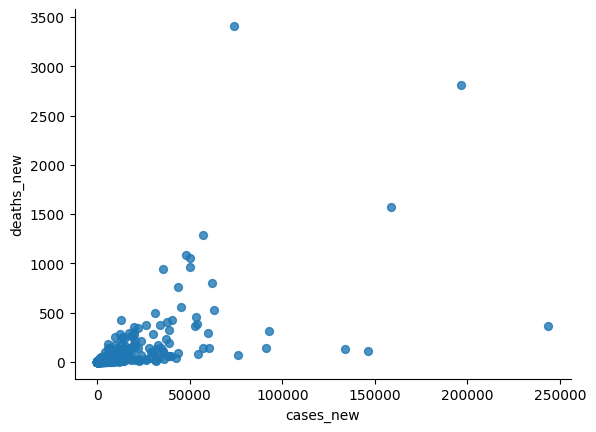

In [ ]:
from matplotlib import pyplot as plt
df1.plot(kind='scatter', x='cases_new', y='deaths_new', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.model_selection import train_test_split

X = df1.drop(['deaths_new', 'cases_new'], axis=1)
y = df1['deaths_new']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test


(492, 164)

In [178]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.20133065379769988

In [228]:
import math
def my_score(y_predict_test, y_test):
  errors=[]
  y_test = y_test.tolist()
  for i in range(len(y_predict_test)):
    errors.append(math.floor(abs(y_predict_test[i]-y_test[i])/0.381))
  return 100-np.mean(errors)

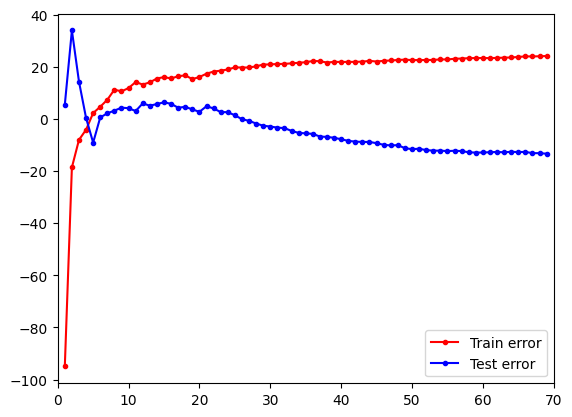

In [229]:
from sklearn import neighbors
kk = range(1, 70)
err_train = []
err_test = []
for k in kk:
    model = neighbors.KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train, y_train)
    err_train.append(5-my_score(model.predict(X_train), y_train))
    err_test.append(5-my_score(model.predict(X_test), y_test))
plt.plot(kk, err_train, '.-r', label = 'Train error')
plt.plot(kk, err_test,  '.-b', label = 'Test error')
plt.legend(loc = 0)
plt.xlim([0, 70])
pass

In [230]:
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train)
my_score(knn_model.predict(X_test), y_test)


0.8658536585365795

In [ ]:
from sklearn import ensemble
gbt = ensemble.GradientBoostingClassifier(n_estimators = 10)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print(err_train, err_test)

0.06910569105691057 0.6280487804878049


In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print(err_train, err_test)

0.006097560975609756 0.6524390243902439
